# Feature Engineering for Stroke Prediction

 **Preparing the processed dataset for modeling** 

### Handling missing data

* The BMI column had 201 NaN values. 
* Since the NaN make up roughly 4% of the value count, the best way to impute is by using median.

### Handling imbalance in the target column

* In the EDA analysis, the split represented c95% of 0s vs c5% of 1s. 
* I shall be considering variuos options to balance out a 50/50 split before proceeding to model training.

### Encoding the categorical features

* One hot encoding is my choice for encoding

In [12]:
#Loading the processed dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../Data/processed_stroke_data.parquet')
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [36]:
#Checking if Mean or Media are better for imputing missing values in 'bmi' column
df['median_imputed'] = df['bmi'].fillna(df['bmi'].median(), inplace=False)
print("Missing values after median imputation:") 
print(df['median_imputed'].isnull().sum())

df['mean_imputed'] = df['bmi'].fillna(df['bmi'].mean(), inplace=False)
print("Missing values after mean imputation:")
print(df['median_imputed'].isnull().sum())


Missing values after median imputation:
0
Missing values after mean imputation:
0


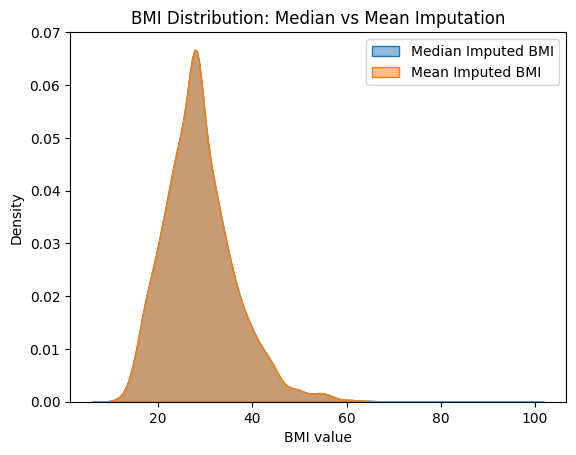

In [ ]:
#Checking the distribution of BMI after imputation

df_compare = pd.DataFrame({
    'Median Imputed BMI': df['median_imputed'],
    'Mean Imputed BMI': df['mean_imputed']
})  
sns.kdeplot(df_compare['Median Imputed BMI'], label='Median Imputed BMI', fill=True, alpha=0.5)
sns.kdeplot(df_compare['Mean Imputed BMI'], label='Mean Imputed BMI', fill=True, alpha=0.5)
plt.title('BMI Distribution: Median vs Mean Imputation')
plt.xlabel('BMI value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
#checking skewness and kurtosis of bmi column
print(df['bmi'].skew())
print(df['bmi'].kurt())
print(df['bmi'].describe())


1.0881872326442346
3.6353059799580927
count    5110.000000
mean       28.862035
std         7.699562
min        10.300000
25%        23.800000
50%        28.100000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64


In [32]:
#selecting median imputation as it preserves the distribution better in presence of skewness
df['bmi'] = df['median_imputed']
df.drop(columns=['median_imputed', 'mean_imputed'], inplace=True)
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64